In [1]:
import pandas as pd
import gc

dtypes = {
    "company_category_code": "category",
    "company_city": "category",
    "company_country_code": "category",
    "company_name": "category",
    "company_region": "category",
    "company_state_code": "category",
    "funded_at": "string",  # consider parsing dates later
    "funding_round_type": "category",
    "investor_category_code": "category",
    "investor_city": "category",
    "investor_country_code": "category",
    "investor_name": "category",
    "investor_region": "category",
    "investor_state_code": "category",
    "raised_amount_usd": "float32",  # or 'Int64' if missing/NaN possible
}
keep_cols = list(dtypes.keys())

chunk_iter = pd.read_csv(
    'crunchbase-investments.csv',
    usecols=keep_cols,
    dtype=dtypes,
    chunksize=5000,
    encoding='Latin-1'
)

cb_length = []

for chunk in chunk_iter:
    # Downcast numeric columns
    chunk['raised_amount_usd'] = pd.to_numeric(chunk['raised_amount_usd'], downcast='float')
    
    # Convert object columns to category if unique ratio < 0.5
    for col in chunk.select_dtypes(include='object').columns:
        num_unique = chunk[col].nunique()
        num_total = len(chunk[col])
        if num_unique / num_total < 0.5:
            chunk[col] = chunk[col].astype('category')
    
    # Ensure RangeIndex to save memory
    chunk.reset_index(drop=True, inplace=True)
    
    cb_length.append(len(chunk))
    del chunk
    import gc; gc.collect()

In [2]:
# Counting missing values by column
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1')

mv_list = []
for chunk in chunk_iter:
    if not mv_list:  # check if mv_list is empty
        columns = chunk.columns
        print(columns.sort_values())
    mv_list.append(chunk.isnull().sum())
combined_mv_vc = pd.concat(mv_list)
unique_combined_mv_vc = combined_mv_vc.groupby(combined_mv_vc.index).sum()
unique_combined_mv_vc

Index(['company_category_code', 'company_city', 'company_country_code',
       'company_name', 'company_permalink', 'company_region',
       'company_state_code', 'funded_at', 'funded_month', 'funded_quarter',
       'funded_year', 'funding_round_type', 'investor_category_code',
       'investor_city', 'investor_country_code', 'investor_name',
       'investor_permalink', 'investor_region', 'investor_state_code',
       'raised_amount_usd'],
      dtype='object')


company_category_code       643
company_city                533
company_country_code          1
company_name                  1
company_permalink             1
company_region                1
company_state_code          492
funded_at                     3
funded_month                  3
funded_quarter                3
funded_year                   3
funding_round_type            3
investor_category_code    50427
investor_city             12480
investor_country_code     12001
investor_name                 2
investor_permalink            2
investor_region               2
investor_state_code       16809
raised_amount_usd          3599
dtype: int64

In [3]:
# Total memory footprint for each column

chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1')
counter = 0
series_memory_fp = pd.Series(dtype='float64')
for chunk in chunk_iter:
    if counter == 0:
        series_memory_fp = chunk.memory_usage(deep=True)
    else:
        series_memory_fp += chunk.memory_usage(deep=True)
    counter += 1

# Drop memory footprint calculation for the index.
series_memory_fp_before = series_memory_fp.drop('Index').sort_values()
series_memory_fp_before

raised_amount_usd          422960
funded_year                422960
investor_category_code     602880
investor_state_code       2188119
investor_country_code     2320340
investor_city             2561163
company_state_code        2687027
company_country_code      2749224
funded_month              2960648
funded_quarter            2960648
investor_region           2973185
funding_round_type        2987771
company_region            2988593
company_category_code     3003288
company_city              3087190
funded_at                 3119249
company_name              3167958
investor_name             3492202
company_permalink         3634836
investor_permalink        4557604
dtype: int64

In [4]:
# Total memory footprint of the data (in megabytes)
series_memory_fp_before.sum() / (1024 * 1024)

50.43777942657471

In [5]:
# Drop columns representing URLs or containing too many missing values (>90% missing)
drop_cols = ['investor_permalink', 'company_permalink', 'investor_category_code', 'funded_month', 'funded_quarter', 'funded_year']
keep_cols = chunk.columns.drop(drop_cols)

In [6]:
# check min, max, and missing values for 'raised_amount_usd'
print("Min:", chunk['raised_amount_usd'].min())
print("Max:", chunk['raised_amount_usd'].max())
print("Missing:", chunk['raised_amount_usd'].isnull().sum())


Min: 3000.0
Max: 275000000.0
Missing: 290


In [74]:
# Downcast 'raised_amount_usd' to float32
chunk['raised_amount_usd'] = pd.to_numeric(chunk['raised_amount_usd'], downcast='float')


In [75]:
# datetime sample values 
print(chunk['funded_at'].dtype)
print(chunk['funded_at'].head())
print(chunk['funded_at'].isnull().sum())  # Count missing/invalid dates

datetime64[ns]
50000   2010-01-01
50001   2010-01-01
50002   2007-11-29
50003   2012-04-17
50004   2012-12-01
Name: funded_at, dtype: datetime64[ns]
0


In [9]:
# convert 'funded_at' to datetime from standard format
chunk['funded_at'] = pd.to_datetime(chunk['funded_at'], errors='coerce')

In [10]:
print(chunk['funded_at'].dtype)
print(chunk['funded_at'].head())
print(chunk['funded_at'].isnull().sum())  # Count missing/invalid dates

datetime64[ns]
50000   2012-10-01
50001   2007-10-01
50002   2008-04-18
50003   2010-01-01
50004   2010-01-01
Name: funded_at, dtype: datetime64[ns]
0


In [14]:
#identify columns with high missing values

for chunk in chunk_iter:
    total_rows += len(chunk)
    chunk_missing = chunk.isnull().sum()
    if missing_counts is None:
        missing_counts = chunk_missing
    else:
        missing_counts += chunk_missing

missing_ratio = missing_counts / total_rows
print(missing_ratio.sort_values(ascending=False))

investor_category_code    0.953792
investor_state_code       0.317931
investor_city             0.236051
investor_country_code     0.226991
raised_amount_usd         0.068073
company_category_code     0.012162
company_city              0.010081
company_state_code        0.009306
funding_round_type        0.000057
funded_at                 0.000057
funded_month              0.000057
funded_quarter            0.000057
funded_year               0.000057
investor_permalink        0.000038
investor_name             0.000038
investor_region           0.000038
company_region            0.000019
company_name              0.000019
company_country_code      0.000019
company_permalink         0.000019
dtype: float64


In [ ]:
#Drop column with >90% missing values
drop_cols = ['investor_category_code']
for chunk in chunk_iter:
    chunk = chunk.drop(columns=drop_cols)

In [18]:
empty_row_count = 0
duplicate_row_count = 0

for chunk in chunk_iter:
    # Count rows where all columns are missing
    empty_row_count += chunk.isnull().all(axis=1).sum()
    
    # Count duplicates within the chunk only
    duplicate_row_count += chunk.duplicated().sum()

print(f"Empty rows: {empty_row_count}")
print(f"Duplicate rows (within chunks): {duplicate_row_count}")

Empty rows: 0
Duplicate rows (within chunks): 0


In [19]:
# Check decimal precision for all float columns
for col in chunk.select_dtypes(include='float'):
    # Count max decimal places for non-null values
    decimals = chunk[col].dropna().apply(lambda x: len(str(x).split('.')[-1]) if '.' in str(x) else 0)
    print(f"{col}: max decimals = {decimals.max()}, median decimals = {decimals.median()}")

investor_category_code: max decimals = nan, median decimals = nan
investor_country_code: max decimals = nan, median decimals = nan
investor_state_code: max decimals = nan, median decimals = nan
investor_city: max decimals = nan, median decimals = nan
raised_amount_usd: max decimals = 1, median decimals = 1.0


In [20]:
# Key: Column name, Value: List of types
col_types = {}
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1', usecols=keep_cols)

for chunk in chunk_iter:
    for col in chunk.columns:
        if col not in col_types:
            col_types[col] = [str(chunk.dtypes[col])]
        else:
            col_types[col].append(str(chunk.dtypes[col]))

In [21]:
uniq_col_types = {}
for k,v in col_types.items():
    uniq_col_types[k] = set(col_types[k])
uniq_col_types

{'company_name': {'object'},
 'company_category_code': {'object'},
 'company_country_code': {'object'},
 'company_state_code': {'object'},
 'company_region': {'object'},
 'company_city': {'object'},
 'investor_name': {'object'},
 'investor_country_code': {'float64', 'object'},
 'investor_state_code': {'float64', 'object'},
 'investor_region': {'object'},
 'investor_city': {'float64', 'object'},
 'funding_round_type': {'object'},
 'funded_at': {'object'},
 'raised_amount_usd': {'float64'}}

In [22]:
chunk.head()

,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,raised_amount_usd
50000,NuORDER,fashion,USA,CA,Los Angeles,West Hollywood,Mortimer Singer,NaN,NaN,unknown,NaN,series-a,2012-10-01,3060000.0
50001,ChaCha,advertising,USA,IN,Indianapolis,Carmel,Morton Meyerson,NaN,NaN,unknown,NaN,series-b,2007-10-01,12000000.0
50002,Binfire,software,USA,FL,Bocat Raton,Bocat Raton,Moshe Ariel,NaN,NaN,unknown,NaN,angel,2008-04-18,500000.0
50003,Binfire,software,USA,FL,Bocat Raton,Bocat Raton,Moshe Ariel,NaN,NaN,unknown,NaN,angel,2010-01-01,750000.0
50004,Unified Color,software,USA,CA,SF Bay,South San Frnacisco,Mr. Andrew Oung,NaN,NaN,unknown,NaN,angel,2010-01-01,NaN


In [ ]:
# Analyzing unique value counts
unique_values = {}

chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1', usecols=keep_cols)
for chunk in chunk_iter:
    for col in chunk.columns:
        if col not in unique_values:
            unique_values[col] = set()
        unique_values[col].update(chunk[col].unique())

for col, unique_vals in unique_values.items():
    print(f"Column: {col}, Unique Values: {len(unique_vals)}")

Column: company_name, Unique Values: 11574
Column: company_category_code, Unique Values: 44
Column: company_country_code, Unique Values: 3
Column: company_state_code, Unique Values: 51
Column: company_region, Unique Values: 547
Column: company_city, Unique Values: 1230
Column: investor_name, Unique Values: 10466
Column: investor_country_code, Unique Values: 75
Column: investor_state_code, Unique Values: 53
Column: investor_region, Unique Values: 586
Column: investor_city, Unique Values: 993
Column: funding_round_type, Unique Values: 10
Column: funded_at, Unique Values: 2809
Column: raised_amount_usd, Unique Values: 1469


In [28]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Choose columns to check for typos
columns_to_check = [
    'company_city', 'company_region', 'company_state_code',
    'investor_city', 'investor_region', 'investor_state_code'
]

# Get unique values for each column
for col in columns_to_check:
    unique_vals = chunk[col].dropna().unique()
    print(f"\nChecking typos in column: {col}")
    # Compare each value to all others
    for val in unique_vals:
        matches = process.extract(val, unique_vals, scorer=fuzz.token_sort_ratio)
        # Print values with high similarity but not identical
        for match_val, score in matches:
            if val != match_val and score > 85:
                print(f"Possible typo: '{val}' vs '{match_val}' (score: {score})")


Checking typos in column: company_city
Possible typo: 'Bocat Raton' vs 'Boca Raton' (score: 95)
Possible typo: 'St. Louis' vs 'St Louis' (score: 100)
Possible typo: 'San Francisco' vs 'SAN FRANCISCO' (score: 100)
Possible typo: 'San Francisco' vs 'San Franciso' (score: 96)
Possible typo: 'San Francisco' vs 'San Francsico' (score: 92)
Possible typo: 'new york' vs 'New York' (score: 100)
Possible typo: 'new york' vs 'New  York' (score: 100)
Possible typo: 'New York' vs 'new york' (score: 100)
Possible typo: 'New York' vs 'New  York' (score: 100)
Possible typo: 'BURBANK' vs 'Burbank' (score: 100)
Possible typo: 'San Mateo' vs 'SAN MATEO' (score: 100)
Possible typo: 'Palo Alto' vs 'Palo-Alto' (score: 100)
Possible typo: 'Palo Alto' vs 'Palo Alto,' (score: 100)
Possible typo: 'Miami' vs 'miami' (score: 100)
Possible typo: 'PORTLAND' vs 'Portland' (score: 100)
Possible typo: 'San Francsico' vs 'San Francisco' (score: 92)
Possible typo: 'San Francsico' vs 'SAN FRANCISCO' (score: 92)
Possible

In [32]:
# Correction mapping for company_city
city_corrections = {
    'Bocat Raton': 'Boca Raton',
    'St Louis': 'St. Louis',
    'new york': 'New York',
    'New  York': 'New York',
    'BURBANK': 'Burbank',
    'SAN FRANCISCO': 'San Francisco',
    'San Franciso': 'San Francisco',
    'San Francsico': 'San Francisco',
    'South San Frnacisco': 'South San Francisco',
    'miami': 'Miami',
    'PORTLAND': 'Portland',
    'SAN MATEO': 'San Mateo',
    'Palo-Alto': 'Palo Alto',
    'Palo Alto,': 'Palo Alto',
    'Bellvue': 'Bellevue'
    # Add more as needed
}

if 'company_city' in chunk.columns:
    chunk['company_city'] = chunk['company_city'].replace(city_corrections)
    chunk['company_city'] = chunk['company_city'].str.title().str.strip()
    print(chunk['company_city'].unique())
else:
    print("Column 'company_city' not found in DataFrame.")

['West Hollywood' 'Carmel' 'Boca Raton' 'South San Francisco'
 'New York City' 'St. Louis' 'San Francisco' nan 'Indianapolis'
 'Santa Clara' 'Menlo Park' 'New York' 'Kenmore' 'Washington' 'Burlingame'
 'Denver' 'Boulder' 'Durham' 'Boston' 'Brooklyn' 'Redwood City' 'Campbell'
 'Minneapolis' 'Burbank' 'San Mateo' 'Sammamish' 'Palo Alto' 'Austin'
 'Seattle' 'Venice' 'Glen Cove' 'Mountain View' 'Provo' 'Cambridge'
 'Chicago' 'West Palm Beach' 'Torrance' 'San Diego' 'Bonita Springs'
 'Reston' 'Miami' 'Culver City' 'Rockford' 'Los Angeles' 'Jersey City'
 'Irving' 'Yonkers' 'Milford' 'Philadelphia' 'Oakland' 'Portland'
 'Houston' 'Long Island City' 'Silver Spring' 'Vienna' 'London'
 'Saint Louis' 'Amherst' 'Tulsa' 'American Fork' 'Bellevue' 'Santa Monica'
 'Atlanta' 'Ny' 'Spokane' 'Corte Madera' 'San Jose' 'Roswell' 'Pittsburgh'
 'Mclean' 'Beverly Hills' 'Des Moines' 'Scottsdale' 'San Antonio'
 'King Of Prussia' 'Richardson' 'Santa Barbara' 'Muskegon' 'Irvington'
 'Vernon Hills' 'Carlsbad' 'T

In [41]:
# Grouped column order
ordered_cols = [
    # Company Info
    'company_name', 'company_category_code', 'company_country_code', 'company_state_code', 'company_region', 'company_city',
    # Investor Info
    'investor_name', 'investor_country_code', 'investor_state_code', 'investor_region', 'investor_city',
    # Funding Info
    'funding_round_type', 'funded_at', 'raised_amount_usd'
]

# Reorder columns in the chunk
chunk = chunk[ordered_cols]
chunk.head()

,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,raised_amount_usd
50000,NuORDER,fashion,USA,CA,Los Angeles,West Hollywood,Mortimer Singer,Unknown,Unknown,unknown,Unknown,series-a,2012-10-01,3060000.0
50001,ChaCha,advertising,USA,IN,Indianapolis,Carmel,Morton Meyerson,Unknown,Unknown,unknown,Unknown,series-b,2007-10-01,12000000.0
50002,Binfire,software,USA,FL,Bocat Raton,Bocat Raton,Moshe Ariel,Unknown,Unknown,unknown,Unknown,angel,2008-04-18,500000.0
50003,Binfire,software,USA,FL,Bocat Raton,Bocat Raton,Moshe Ariel,Unknown,Unknown,unknown,Unknown,angel,2010-01-01,750000.0
50004,Unified Color,software,USA,CA,SF Bay,South San Frnacisco,Mr. Andrew Oung,Unknown,Unknown,unknown,Unknown,angel,2010-01-01,1375000.0


In [42]:
# Compute missing ratio on entire dataset
missing_counts_total = None
total_rows = 0

chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1')
for chunk in chunk_iter:
    if missing_counts_total is None:
        missing_counts_total = chunk.isnull().sum()
    else:
        missing_counts_total += chunk.isnull().sum()
    total_rows += len(chunk)

missing_ratio = missing_counts_total / total_rows
print("Missing value ratio per column (entire dataset):\n", missing_ratio.sort_values(ascending=False))

# Columns to drop
cols_to_drop = missing_ratio[missing_ratio > 0.9].index.tolist()
print(f"Dropping columns: {cols_to_drop}")

# Process chunks
processed_chunks = []

chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1')
for chunk in chunk_iter:
    # Drop columns consistently
    chunk = chunk.drop(columns=cols_to_drop)
    
    # Fill missing values intelligently
    # For numeric columns: median imputation example
    numeric_cols = chunk.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        median_val = chunk[col].median()
        chunk[col].fillna(median_val, inplace=True)
    
    # For categorical columns: fill with 'Unknown'
    categorical_cols = chunk.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        chunk[col] = chunk[col].where(pd.notnull(chunk[col]), None)
    
    processed_chunks.append(chunk)

# Concatenate or save processed data
df_cleaned = pd.concat(processed_chunks)
df_cleaned.to_csv('crunchbase-investments-cleaned.csv', index=False)
print("Data cleaning complete; saved to crunchbase-investments-cleaned.csv")


Missing value ratio per column (entire dataset):
 investor_category_code    0.953792
investor_state_code       0.317931
investor_city             0.236051
investor_country_code     0.226991
raised_amount_usd         0.068073
company_category_code     0.012162
company_city              0.010081
company_state_code        0.009306
funding_round_type        0.000057
funded_at                 0.000057
funded_month              0.000057
funded_quarter            0.000057
funded_year               0.000057
investor_permalink        0.000038
investor_name             0.000038
investor_region           0.000038
company_region            0.000019
company_name              0.000019
company_country_code      0.000019
company_permalink         0.000019
dtype: float64
Dropping columns: ['investor_category_code']


C:\Users\joshu\AppData\Local\Temp\ipykernel_16216\2781095471.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk[col].fillna(median_val, inplace=True)
C:\Users\joshu\AppData\Local\Temp\ipykernel_16216\2781095471.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

Data cleaning complete; saved to crunchbase-investments-cleaned.csv


In [43]:
# Open a chunked iterator
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1')

# Write cleaned chunks directly to CSV (incrementally) to avoid storing all in memory
with open('crunchbase-investments-cleaned.csv', 'w', encoding='utf-8', newline='') as f_out:
    first_chunk = True  # To write header once

    for chunk in chunk_iter:
        # Drop high-missing column
        chunk.drop(columns=['investor_category_code'], inplace=True, errors='ignore')

        # Fill missing in categorical as 'Unknown'
        categorical_cols = ['investor_state_code', 'investor_city', 'investor_country_code',
                            'company_category_code', 'company_city', 'company_state_code']
        for col in categorical_cols:
            if col in chunk.columns:
                chunk[col] = chunk[col].fillna('Unknown')

        # Impute missing in raised_amount_usd (use per-chunk median)
        if 'raised_amount_usd' in chunk.columns:
            median_usd = chunk['raised_amount_usd'].median()
            chunk['raised_amount_usd'] = chunk['raised_amount_usd'].fillna(median_usd)

        # Fill funding_round_type with mode
        if 'funding_round_type' in chunk.columns:
            mode_val = chunk['funding_round_type'].mode()
            if not mode_val.empty:
                chunk['funding_round_type'] = chunk['funding_round_type'].fillna(mode_val[0])

        # Drop rows with missing critical date 
        if 'funded_at' in chunk.columns:
            chunk.dropna(subset=['funded_at'], inplace=True)

        # Convert funded_at to datetime
        chunk['funded_at'] = pd.to_datetime(chunk['funded_at'], errors='coerce')

        # Write to file in append mode
        chunk.to_csv(f_out, index=False, header=first_chunk)
        first_chunk = False  # Only write header on first chunk


In [45]:
chunk.head()

,company_permalink,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
50000,/company/nuorder,NuORDER,fashion,USA,CA,Los Angeles,West Hollywood,/person/mortimer-singer,Mortimer Singer,Unknown,Unknown,unknown,Unknown,series-a,2012-10-01,2012-10,2012-Q4,2012,3060000.0
50001,/company/chacha,ChaCha,advertising,USA,IN,Indianapolis,Carmel,/person/morton-meyerson,Morton Meyerson,Unknown,Unknown,unknown,Unknown,series-b,2007-10-01,2007-10,2007-Q4,2007,12000000.0
50002,/company/binfire,Binfire,software,USA,FL,Bocat Raton,Bocat Raton,/person/moshe-ariel,Moshe Ariel,Unknown,Unknown,unknown,Unknown,angel,2008-04-18,2008-04,2008-Q2,2008,500000.0
50003,/company/binfire,Binfire,software,USA,FL,Bocat Raton,Bocat Raton,/person/moshe-ariel,Moshe Ariel,Unknown,Unknown,unknown,Unknown,angel,2010-01-01,2010-01,2010-Q1,2010,750000.0
50004,/company/unified-color,Unified Color,software,USA,CA,SF Bay,South San Frnacisco,/person/mr-andrew-oung,Mr. Andrew Oung,Unknown,Unknown,unknown,Unknown,angel,2010-01-01,2010-01,2010-Q1,2010,1375000.0


In [ ]:
# Load chunks into SQLite 

import pandas as pd
import sqlite3

# Use your previously defined dtypes and keep_cols
conn = sqlite3.connect('crunchbase2.db')

chunk_iter = pd.read_csv(
    'crunchbase-investments-cleaned.csv',
    usecols=keep_cols,
    dtype=dtypes,
    chunksize=5000,
    encoding='Latin-1',
    parse_dates=['funded_at']
)

for chunk in chunk_iter:
    chunk.to_sql('investments', conn, if_exists='append', index=False)

conn.close()

In [72]:
cursor.execute("SELECT * FROM investments LIMIT 5;")
print(cursor.fetchall())

[('AdverCar', 'advertising', 'USA', 'CA', 'SF Bay', 'San Francisco', '1-800-FLOWERS.COM', 'USA', 'NY', 'New York', 'New York', 'series-a', '2012-10-30 00:00:00', 2000000.0), ('LaunchGram', 'news', 'USA', 'CA', 'SF Bay', 'Mountain View', '10Xelerator', 'USA', 'OH', 'Columbus', 'Columbus', 'other', '2012-01-23 00:00:00', 20000.0), ('uTaP', 'messaging', 'USA', None, 'United States - Other', None, '10Xelerator', 'USA', 'OH', 'Columbus', 'Columbus', 'other', '2012-01-01 00:00:00', 20000.0), ('ZoopShop', 'software', 'USA', 'OH', 'Columbus', 'columbus', '10Xelerator', 'USA', 'OH', 'Columbus', 'Columbus', 'angel', '2012-02-15 00:00:00', 20000.0), ('eFuneral', 'web', 'USA', 'OH', 'Cleveland', 'Cleveland', '10Xelerator', 'USA', 'OH', 'Columbus', 'Columbus', 'other', '2011-09-08 00:00:00', 20000.0)]


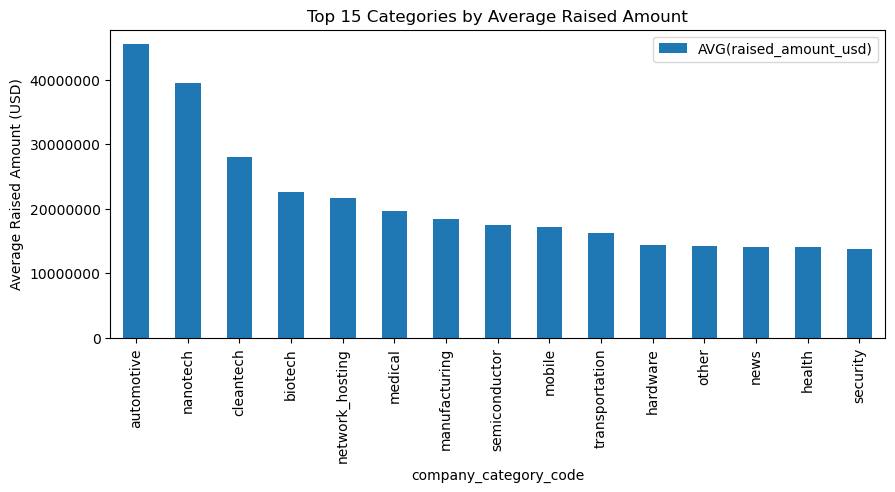

In [73]:
pd.set_option('display.float_format', '{:.2f}'.format)


df = pd.read_sql("""
                SELECT company_category_code, AVG(raised_amount_usd)
                FROM investments
                GROUP BY company_category_code
                ORDER BY AVG(raised_amount_usd) DESC;""", 
                conn)
df = df.set_index('company_category_code')

top_n = 15  # or any number that looks best
ax = df.head(top_n).plot(kind='bar', figsize=(10, 4))
ax.set_ylabel('Average Raised Amount (USD)')
ax.set_title(f'Top {top_n} Categories by Average Raised Amount')
ax.ticklabel_format(style='plain', axis='y')

In [53]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('crunchbase2.db')

# Compute total investment per company
company_totals = pd.read_sql_query("""
    SELECT company_name, SUM(raised_amount_usd) as total_investment
    FROM investments
    GROUP BY company_name
""", conn)

# Top 10%
top_10pct = company_totals.nlargest(int(len(company_totals)*0.1), 'total_investment')
# Bottom 10%
bottom_10pct = company_totals.nsmallest(int(len(company_totals)*0.1), 'total_investment')
# Top 1%
top_1pct = company_totals.nlargest(max(1, int(len(company_totals)*0.01)), 'total_investment')
# Bottom 1%
bottom_1pct = company_totals.nsmallest(max(1, int(len(company_totals)*0.01)), 'total_investment')

print("Top 10% companies by total investment:\n", top_10pct)
print("Bottom 10% companies by total investment:\n", bottom_10pct)
print("Top 1% companies by total investment:\n", top_1pct)
print("Bottom 1% companies by total investment:\n", bottom_1pct)

Top 10% companies by total investment:
           company_name  total_investment
2047         Clearwire      5.936000e+10
4104           Groupon      2.037080e+10
6263         Nanosolar      9.010000e+09
3359          Facebook      8.308200e+09
9339      SurveyMonkey      6.516500e+09
...                ...               ...
1307         Blu Homes      2.750000e+08
3322   ExteNet Systems      2.750000e+08
6214            Mzinga      2.750000e+08
11480           ngmoco      2.748000e+08
2578        DATAllegro      2.744000e+08

[1158 rows x 2 columns]
Bottom 10% companies by total investment:
              company_name  total_investment
5612    Main Street Stark            2000.0
11554            uromovie            4000.0
10723          WhiteWilly            6000.0
4576             IndyGeek            6200.0
7176   PictureMe Universe            8000.0
...                   ...               ...
7473             ProBueno         1360000.0
1256                Bizak         1375000.0
1404

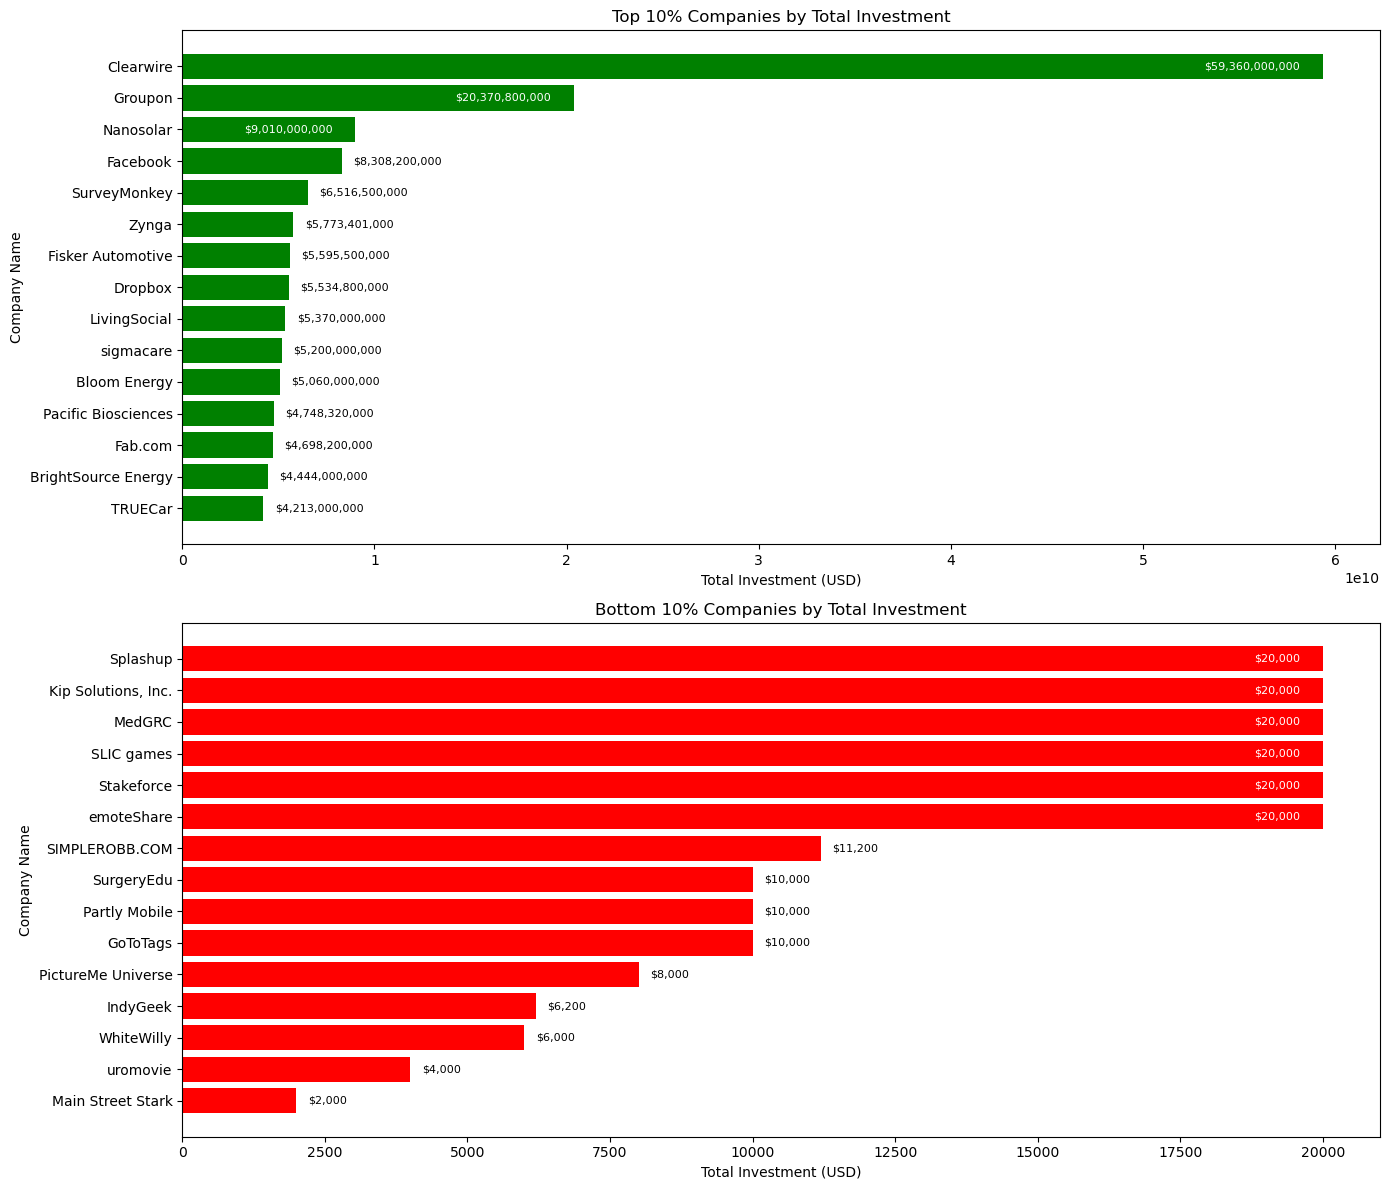

In [60]:
import matplotlib.pyplot as plt

def annotate_bars(ax, values, bar_container, threshold_frac=0.15):
    """
    Annotate bars with their values.
    If the bar is long enough (relative to max), annotate inside, else outside.
    threshold_frac: fraction of max for putting text inside bar.
    """
    max_val = max(values)
    for bar, value in zip(bar_container, values):
        width = bar.get_width()
        y = bar.get_y() + bar.get_height()/2
        if width > threshold_frac * max_val:
            # Inside bar
            ax.text(width - 0.02*max_val, y, f'${value:,.0f}', va='center', ha='right', color='white', fontsize=8)
        else:
            # Outside bar
            ax.text(width + 0.01*max_val, y, f'${value:,.0f}', va='center', ha='left', color='black', fontsize=8)

# Show only top/bottom N for clarity
top_N = 15
df_top10_sorted = top_10pct.sort_values('total_investment', ascending=True).tail(top_N)
df_bottom10_sorted = bottom_10pct.sort_values('total_investment', ascending=True).head(top_N)

fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

# --- Top 10% ---
ax = axes[0]
bars = ax.barh(df_top10_sorted['company_name'], df_top10_sorted['total_investment'], color='green')
ax.set_title('Top 10% Companies by Total Investment')
ax.set_xlabel('Total Investment (USD)')
ax.set_ylabel('Company Name')
annotate_bars(ax, df_top10_sorted['total_investment'], bars, threshold_frac=0.15)

# --- Bottom 10% ---
ax = axes[1]
bars = ax.barh(df_bottom10_sorted['company_name'], df_bottom10_sorted['total_investment'], color='red')
ax.set_title('Bottom 10% Companies by Total Investment')
ax.set_xlabel('Total Investment (USD)')
ax.set_ylabel('Company Name')
annotate_bars(ax, df_bottom10_sorted['total_investment'], bars, threshold_frac=0.80)  # most bars are short, use higher threshold

plt.tight_layout()
plt.show()


In [56]:
# Companies that attract most investment
print("Companies attracting most investment:\n", top_10pct.head(10))

Companies attracting most investment:
             company_name  total_investment
2047           Clearwire      5.936000e+10
4104             Groupon      2.037080e+10
6263           Nanosolar      9.010000e+09
3359            Facebook      8.308200e+09
9339        SurveyMonkey      6.516500e+09
11152              Zynga      5.773401e+09
3507   Fisker Automotive      5.595500e+09
2897             Dropbox      5.534800e+09
5403        LivingSocial      5.370000e+09
11517          sigmacare      5.200000e+09


C:\Users\joshu\AppData\Local\Temp\ipykernel_16216\2689929931.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


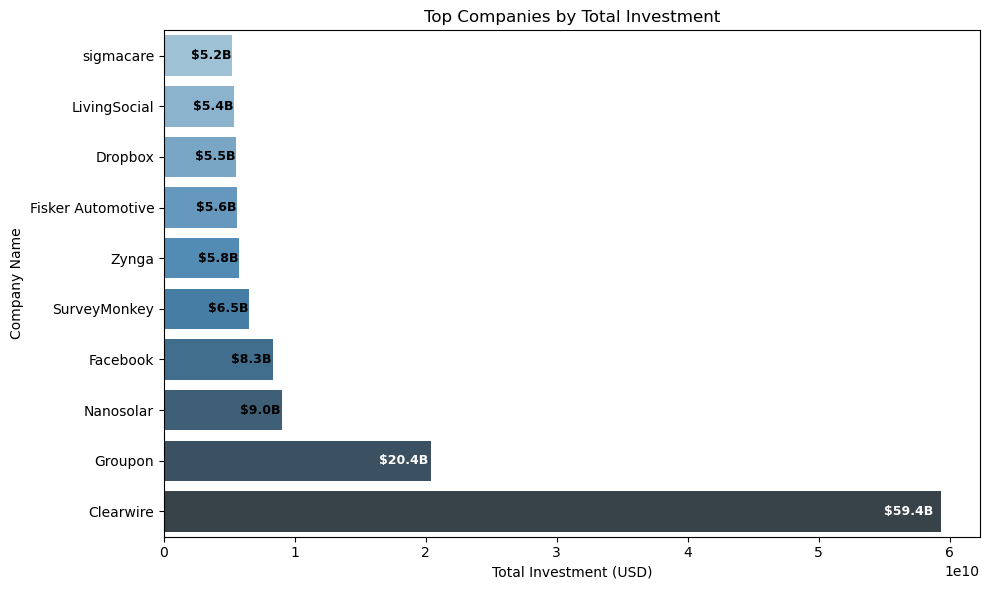

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# top companies data
data = {
    'company_name': [
        'Clearwire', 'Groupon', 'Nanosolar', 'Facebook', 'SurveyMonkey', 
        'Zynga', 'Fisker Automotive', 'Dropbox', 'LivingSocial', 'sigmacare'
    ],
    'total_investment': [
        5.936e+10, 2.03708e+10, 9.01e+9, 8.3082e+9, 6.5165e+9,
        5.773401e+9, 5.5955e+9, 5.5348e+9, 5.37e+9, 5.2e+9
    ]
}

df = pd.DataFrame(data)
df = df.sort_values('total_investment', ascending=True)  # For horizontal bar plot

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df, 
    x='total_investment', 
    y='company_name', 
    palette="Blues_d"
)

# Add data labels 
for i, value in enumerate(df['total_investment']):
    label = f'${value/1e9:.1f}B'
    ax.text(
        value * 0.99,  # Slightly inside the bar
        i, 
        label, 
        va='center', 
        ha='right', 
        fontsize=9, 
        color='white' if value > df['total_investment'].max() * 0.2 else 'black',
        fontweight='bold'
    )

plt.xlabel('Total Investment (USD)')
plt.ylabel('Company Name')
plt.title('Top Companies by Total Investment')
plt.tight_layout()
plt.show()

In [62]:
# Investors who invested most (total and per startup)

# Total investment by investor
investor_totals = pd.read_sql_query("""
    SELECT investor_name, SUM(raised_amount_usd) as total_invested
    FROM investments
    GROUP BY investor_name
    ORDER BY total_invested DESC
    LIMIT 10
""", conn)
print("Top investors by total invested:\n", investor_totals)

# Average investment per startup by investor
investor_per_startup = pd.read_sql_query("""
    SELECT investor_name, AVG(raised_amount_usd) as avg_investment_per_startup
    FROM investments
    GROUP BY investor_name
    ORDER BY avg_investment_per_startup DESC
    LIMIT 10
""", conn)
print("Top investors by average investment per startup:\n", investor_per_startup)

Top investors by total invested:
                       investor_name  total_invested
0  Kleiner Perkins Caufield & Byers    2.261565e+10
1         New Enterprise Associates    1.944726e+10
2                    Accel Partners    1.301025e+10
3                     Goldman Sachs    1.281842e+10
4                   Sequoia Capital    1.223080e+10
5                             Intel    1.195640e+10
6                            Google    1.162960e+10
7                       Time Warner    1.146600e+10
8                           Comcast    1.133800e+10
9                 Greylock Partners    1.000447e+10
Top investors by average investment per startup:
               investor_name  avg_investment_per_startup
0    Marlin Equity Partners                2.600000e+09
1               BrightHouse                2.350000e+09
2               GI Partners                1.050000e+09
3             Sprint Nextel                8.333333e+08
4      Siemens PLM Software                7.500000e+08
5       

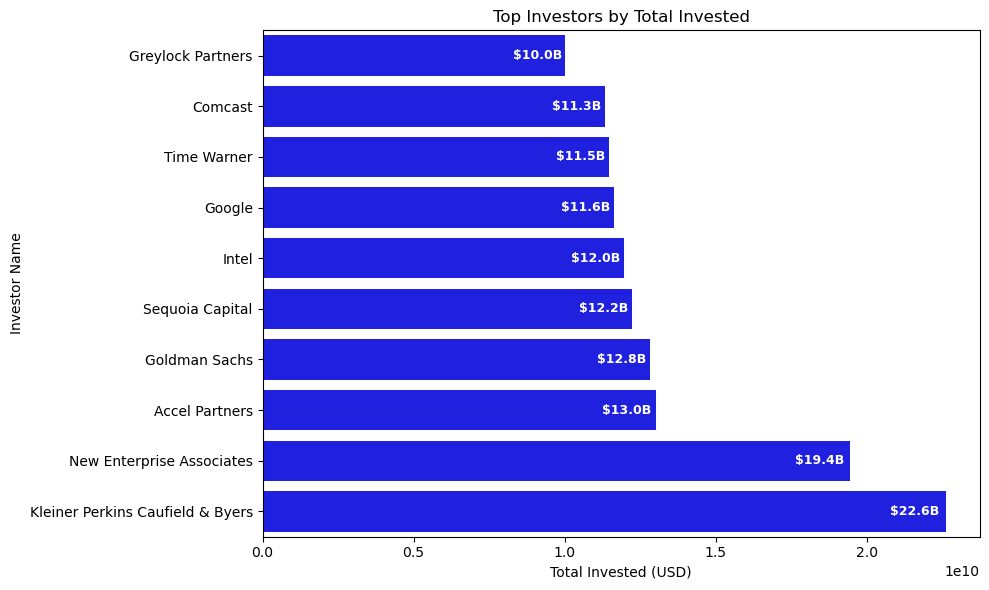

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_total = pd.DataFrame({
    'investor_name': [
        'Kleiner Perkins Caufield & Byers', 'New Enterprise Associates',
        'Accel Partners', 'Goldman Sachs', 'Sequoia Capital',
        'Intel', 'Google', 'Time Warner', 'Comcast', 'Greylock Partners'
    ],
    'total_invested': [
        2.261565e+10, 1.944726e+10, 1.301025e+10, 1.281842e+10,
        1.223080e+10, 1.195640e+10, 1.162960e+10, 1.146600e+10,
        1.133800e+10, 1.000447e+10
    ]
})

df_total = df_total.sort_values('total_invested', ascending=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_total, 
    x='total_invested', y='investor_name', color='b'
)

# Add data labels
for i, value in enumerate(df_total['total_invested']):
    label = f'${value/1e9:.1f}B'
    ax.text(
        value * 0.99,  # Slightly inside the bar
        i, 
        label, 
        va='center', 
        ha='right', 
        fontsize=9, 
        color='white' if value > df_total['total_invested'].max() * 0.2 else 'black',
        fontweight='bold'
    )

plt.xlabel('Total Invested (USD)')
plt.ylabel('Investor Name')
plt.title('Top Investors by Total Invested')
plt.tight_layout()

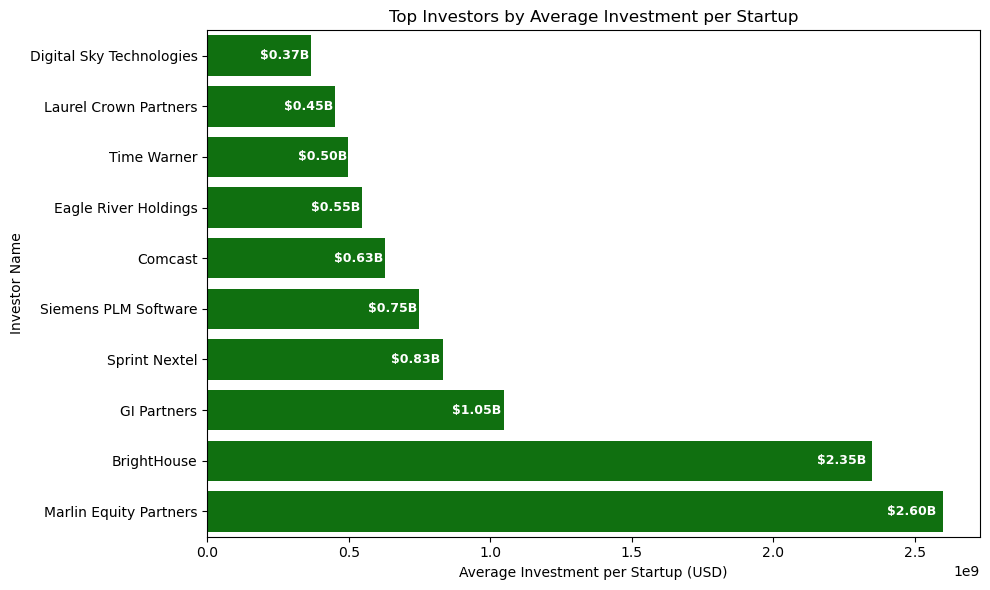

In [69]:
df_avg = pd.DataFrame({
    'investor_name': [
        'Marlin Equity Partners', 'BrightHouse', 'GI Partners',
        'Sprint Nextel', 'Siemens PLM Software', 'Comcast',
        'Eagle River Holdings', 'Time Warner', 'Laurel Crown Partners', 'Digital Sky Technologies'
    ],
    'avg_investment_per_startup': [
        2.600000e+09, 2.350000e+09, 1.050000e+09, 8.333333e+08, 7.500000e+08,
        6.298889e+08, 5.468889e+08, 4.985217e+08, 4.500000e+08, 3.652259e+08
    ]
})

plt.figure(figsize=(10, 6))
df_avg_sorted = df_avg.sort_values('avg_investment_per_startup', ascending=True)
ax = sns.barplot(
    data=df_avg_sorted,
    x='avg_investment_per_startup', y='investor_name', color='g'
)

# Add data labels
for i, value in enumerate(df_avg_sorted['avg_investment_per_startup']):
    label = f'${value/1e9:.2f}B'
    ax.text(
        value * 0.99,  # Slightly inside the bar
        i,
        label,
        va='center',
        ha='right',
        fontsize=9,
        color='white',
        fontweight='bold'
    )

plt.xlabel('Average Investment per Startup (USD)')
plt.ylabel('Investor Name')
plt.title('Top Investors by Average Investment per Startup')
plt.tight_layout()

In [ ]:
# Most Popular Funding Round 

funding_popularity = pd.read_sql_query("""
    SELECT funding_round_type, COUNT(*) as num_rounds
    FROM investments
    GROUP BY funding_round_type
    ORDER BY num_rounds DESC
""", conn)
print("Most popular funding rounds:\n", funding_popularity)

Most popular funding rounds:
   funding_round_type  num_rounds
0           series-a       27876
1          series-c+       21740
2              angel       17978
3            venture       17834
4           series-b       17588
5              other        1928
6     private-equity         714
7           post-ipo          66
8       crowdfunding          10
9               None           3


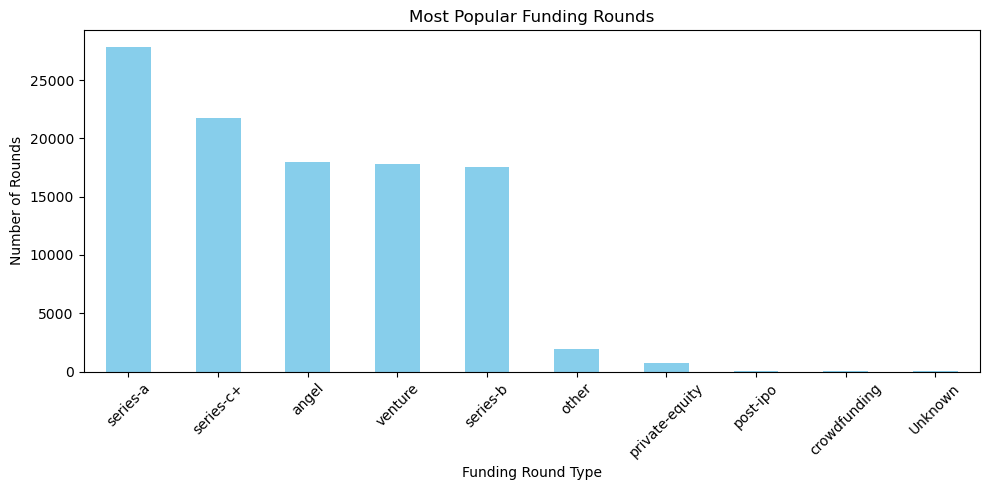

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for funding rounds
data = {
    'funding_round_type': [
        'series-a', 'series-c+', 'angel', 'venture', 'series-b',
        'other', 'private-equity', 'post-ipo', 'crowdfunding', None
    ],
    'num_rounds': [
        27876, 21740, 17978, 17834, 17588,
        1928, 714, 66, 10, 3
    ]
}

df = pd.DataFrame(data)

# Replace None with 'Unknown' for display
df['funding_round_type'] = df['funding_round_type'].fillna('Unknown')

# Create bar plot
ax = df.plot.bar(
    x='funding_round_type', 
    y='num_rounds', 
    legend=False, 
    figsize=(10,5), 
    color='skyblue'
)
ax.set_xlabel('Funding Round Type')
ax.set_ylabel('Number of Rounds')
ax.set_title('Most Popular Funding Rounds')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
